## Import required packages

In [9]:
from IPython.display import Image
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.io import loadmat
import torch
import torch.nn as nn
import random
import pickle
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader


In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
%cd /content/gdrive/My Drive/rec_system_gnn

/content/gdrive/My Drive/rec_system_gnn


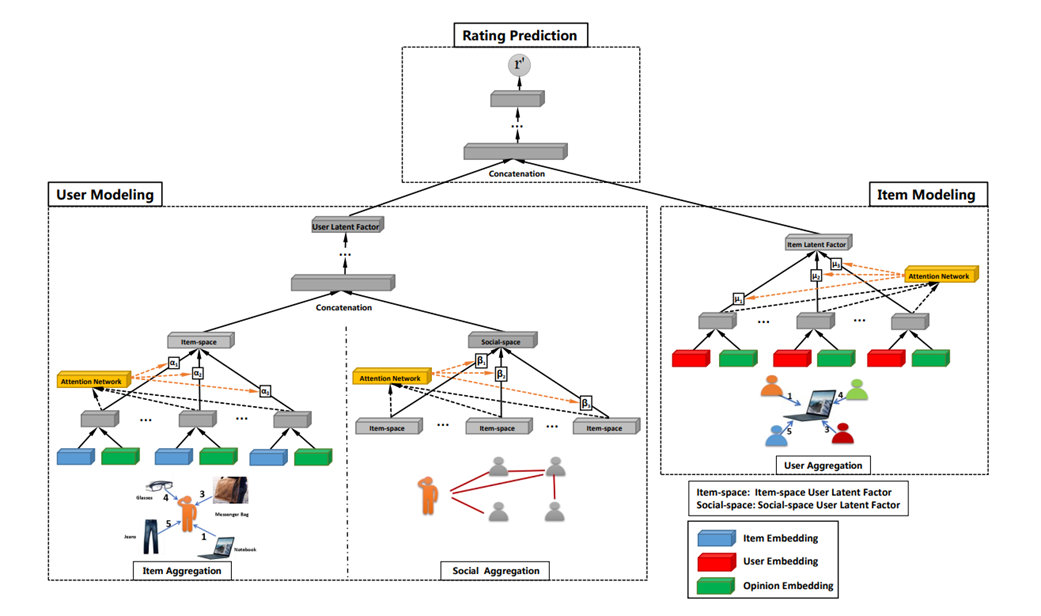

In [12]:
Image('./rec_system_arch.png')

## Load the data

In [13]:


rating_info = loadmat('./epinions/rating.mat')['rating']
trust_info = loadmat('./epinions/trustnetwork.mat')['trustnetwork']



In [14]:
rating_info

array([[    1,     1,     3,     2],
       [    1,     2,     2,     2],
       [    1,     3,     3,     2],
       ...,
       [22166, 43538,     5,     5],
       [22166, 38711,     3,     4],
       [22166, 41790,     5,     3]], dtype=int32)

In [15]:
trust_info

array([[15373,  9831],
       [ 4247,  9831],
       [ 4644,  9831],
       ...,
       [13181, 15645],
       [  897,  8000],
       [ 8000,   897]], dtype=uint16)

In [16]:


rating_list = []
trust_list = []

u_items_list = []
u_users_list = []
u_users_items_list = []
i_users_list = []

user_count = 0
item_count = 0
rate_count = 0



In [17]:
for x in rating_info:
    uid = x[0]
    iid = x[1]
    label = x[2]
    user_count = max(user_count, uid)
    item_count = max(item_count, iid)
    rate_count = max(rate_count, label)
    rating_list.append([uid, iid, label])

In [18]:
pos_list = []
for x in rating_list:
	pos_list.append((x[0], x[1], x[2]))

In [19]:
user_count, item_count, rate_count

(22166, 296277, 27)

In [20]:
pos_list[0]

(1, 1, 3)

## Prepare train, valid, test split of data

In [21]:

  
pos_list = list(set(pos_list))
random.shuffle(pos_list)
num_test = int(len(pos_list) * 0.1)
test_set = pos_list[:num_test]
valid_set = pos_list[num_test:2 * num_test]
train_set = pos_list[2 * num_test:]
print('Train samples: {}, Valid samples: {}, Test samples: {}'.format(len(train_set), len(valid_set), len(test_set)))



Train samples: 730054, Valid samples: 91256, Test samples: 91256


## Saving the data in a pickle file

In [22]:


with open('./dataset_epinions.pkl', 'wb') as f:
	pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)
	pickle.dump(valid_set, f, pickle.HIGHEST_PROTOCOL)
	pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)



In [23]:


train_df = pd.DataFrame(train_set, columns = ['uid', 'iid', 'label'])
valid_df = pd.DataFrame(valid_set, columns = ['uid', 'iid', 'label'])
test_df = pd.DataFrame(test_set, columns = ['uid', 'iid', 'label'])

click_df = pd.DataFrame(rating_list, columns = ['uid', 'iid', 'label'])
train_df = train_df.sort_values(axis = 0, ascending = True, by = 'uid')



In [26]:
train_df

,uid,iid,label
338142,1,1,3
622419,1,7,3
560643,1,3,3
715095,1,2,2
482207,1,6,11
...,...,...,...
430953,22166,43538,5
557027,22166,83922,5
92915,22166,80536,3
271280,22166,23442,5


In [25]:
max(train_df['label'].values.tolist())

27

In [27]:
min(train_df['label'].values.tolist())

1

## Prepare user-item list


In [30]:
for user in tqdm(range(user_count + 1)):
    user_df = train_df[train_df['uid'] == user]
    user_items = user_df['iid'].tolist()
    user_ratings = user_df['label'].tolist()
    if len(user_items) == 0:
        u_items_list.append([(0, 0)])
    else:
        u_items_list.append([(iid, rating) for iid, rating in zip(user_items, user_ratings)])

100%|██████████| 22167/22167 [00:20<00:00, 1105.16it/s]


In [31]:
u_items_list[3]

[(42, 9),
 (48, 2),
 (50, 10),
 (57, 15),
 (53, 10),
 (49, 11),
 (55, 11),
 (47, 15),
 (56, 11),
 (52, 11),
 (54, 11),
 (51, 1)]

# Prepare Item User List

In [32]:


for item in tqdm(range(item_count + 1)):
    item_df = train_df[train_df['iid'] == item]
    item_users = item_df['uid'].tolist()
    item_ratings = item_df['label'].tolist()
    if len(item_users) == 0:
        i_users_list.append([(0, 0)])
    else:
        i_users_list.append([(uid, rating) for uid, rating in zip(item_users, item_ratings)])



100%|██████████| 296278/296278 [04:14<00:00, 1165.65it/s]


In [33]:
i_users_list[2]

[(1, 2),
 (36, 2),
 (174, 2),
 (562, 2),
 (840, 2),
 (1266, 2),
 (1342, 2),
 (1351, 2),
 (1403, 2),
 (1729, 2),
 (2201, 2),
 (2525, 2),
 (2577, 2),
 (2652, 2),
 (3067, 2),
 (3326, 2),
 (3334, 2),
 (3446, 2),
 (3626, 2),
 (3939, 2),
 (4031, 2),
 (4057, 2),
 (4138, 2),
 (4292, 2),
 (4330, 2),
 (4466, 2),
 (4680, 2),
 (4938, 2),
 (4961, 2),
 (4977, 2),
 (5113, 2),
 (5343, 2),
 (5482, 2),
 (5646, 2),
 (5754, 2),
 (5770, 2),
 (5828, 2),
 (5912, 2),
 (5939, 2),
 (6185, 2),
 (6245, 2),
 (6326, 2),
 (6412, 2),
 (6664, 2),
 (6752, 2),
 (6764, 2),
 (6923, 2),
 (7030, 2),
 (7097, 2),
 (7145, 2),
 (7148, 2),
 (7216, 2),
 (7468, 2),
 (7525, 2),
 (7618, 2),
 (7692, 2),
 (8419, 2),
 (8495, 2),
 (8803, 2),
 (8810, 2),
 (8925, 2),
 (9054, 2),
 (9432, 2),
 (9729, 2),
 (9872, 2),
 (9898, 2),
 (10008, 2),
 (10097, 2),
 (10233, 2),
 (10329, 2),
 (11207, 2),
 (11353, 2),
 (11600, 2),
 (11801, 2),
 (12085, 2),
 (12107, 2),
 (12146, 2),
 (12181, 2),
 (12647, 2),
 (12653, 2),
 (12807, 2),
 (13283, 2),
 (13812,

## Process trust info

In [34]:


for x in trust_info:
    uid = x[0]
    fid = x[1]
    if uid > user_count or fid > user_count:
        continue
    trust_list.append([uid, fid])



In [35]:


trust_df = pd.DataFrame(trust_list, columns = ['uid', 'fid'])
trust_df = trust_df.sort_values(axis = 0, ascending = True, by = 'uid')



In [36]:
trust_df

,uid,fid
283312,2,7659
84889,2,829
221672,2,21911
247685,2,7336
306637,2,6339
...,...,...
285484,22164,5864
283826,22164,11427
285362,22164,10897
135466,22165,2198


In [37]:


for user in tqdm(range(user_count + 1)):
    user_df = trust_df[trust_df['uid'] == user]
    u_users = user_df['fid'].unique().tolist()
    if len(u_users) == 0:
        u_users_list.append([0])
        u_users_items_list.append([[(0, 0)]])
    else:
        u_users_list.append(u_users)
        uu_items = []
        for uid in u_users:
            uu_items.append(u_items_list[uid])
        u_users_items_list.append(uu_items)



100%|██████████| 22167/22167 [00:20<00:00, 1080.09it/s]


In [ ]:


with open('./list_epinions.pkl', 'wb') as f:
	pickle.dump(u_items_list, f, pickle.HIGHEST_PROTOCOL)
	pickle.dump(u_users_list, f, pickle.HIGHEST_PROTOCOL)
	pickle.dump(u_users_items_list, f, pickle.HIGHEST_PROTOCOL)
	pickle.dump(i_users_list, f, pickle.HIGHEST_PROTOCOL)
	pickle.dump((user_count, item_count, rate_count), f, pickle.HIGHEST_PROTOCOL)



## Prepare GraphDataset Class

In [38]:
class GraphDataset(Dataset):
    def __init__(self, data, u_items_list, u_user_list, u_users_items_list, i_users_list):
        self.data = data
        self.u_items_list = u_items_list
        self.u_users_list = u_user_list
        self.u_users_items_list = u_users_items_list
        self.i_users_list = i_users_list
    
    def __getitem__(self, index):
        uid = self.data[index][0]
        iid = self.data[index][1]
        label = self.data[index][2]
        u_items = self.u_items_list[uid]
        u_users = self.u_users_list[uid]
        u_users_items = self.u_users_items_list[uid]
        i_users = self.i_users_list[iid]

        return (uid, iid, label), u_items, u_users, u_users_items, i_users

    def __len__(self):
        return len(self.data)

## Collate function for padding and truncation

In [39]:


truncate_len = 50

def collate_fn(batch_data):

    uids, iids, labels = [], [], []
    u_items, u_users, u_users_items, i_users = [], [], [], []
    u_items_len, u_users_len, i_users_len = [], [], []

    for data, u_items_u, u_users_u, u_users_items_u, i_users_i in batch_data:

        (uid, iid, label) = data
        uids.append(uid)
        iids.append(iid)
        labels.append(label)

        # user-items
        if len(u_items_u) <= truncate_len:
            u_items.append(u_items_u)
        else:
            u_items.append(random.sample(u_items_u, truncate_len))
        u_items_len.append(min(len(u_items_u), truncate_len))
        
        # user-users and user-users-items
        if len(u_users_u) <= truncate_len:
            u_users.append(u_users_u)
            u_u_items = [] 
            for uui in u_users_items_u:
                if len(uui) < truncate_len:
                    u_u_items.append(uui)
                else:
                    u_u_items.append(random.sample(uui, truncate_len))
            u_users_items.append(u_u_items)
        else:
            sample_index = random.sample(list(range(len(u_users_u))), truncate_len)
            u_users.append([u_users_u[si] for si in sample_index])

            u_users_items_u_tr = [u_users_items_u[si] for si in sample_index]
            u_u_items = [] 
            for uui in u_users_items_u_tr:
                if len(uui) < truncate_len:
                    u_u_items.append(uui)
                else:
                    u_u_items.append(random.sample(uui, truncate_len))
            u_users_items.append(u_u_items)

        u_users_len.append(min(len(u_users_u), truncate_len))	

        # item-users
        if len(i_users_i) <= truncate_len:
            i_users.append(i_users_i)
        else:
            i_users.append(random.sample(i_users_i, truncate_len))
        i_users_len.append(min(len(i_users_i), truncate_len))

    batch_size = len(batch_data)

    # padding
    u_items_maxlen = max(u_items_len)
    u_users_maxlen = max(u_users_len)
    i_users_maxlen = max(i_users_len)
    
    u_item_pad = torch.zeros([batch_size, u_items_maxlen, 2], dtype=torch.long)
    for i, ui in enumerate(u_items):
        u_item_pad[i, :len(ui), :] = torch.LongTensor(ui)
    
    u_user_pad = torch.zeros([batch_size, u_users_maxlen], dtype=torch.long)
    for i, uu in enumerate(u_users):
        u_user_pad[i, :len(uu)] = torch.LongTensor(uu)
    
    u_user_item_pad = torch.zeros([batch_size, u_users_maxlen, u_items_maxlen, 2], dtype=torch.long)
    for i, uu_items in enumerate(u_users_items):
        for j, ui in enumerate(uu_items):
            u_user_item_pad[i, j, :len(ui), :] = torch.LongTensor(ui)

    i_user_pad = torch.zeros([batch_size, i_users_maxlen, 2], dtype=torch.long)
    for i, iu in enumerate(i_users):
        i_user_pad[i, :len(iu), :] = torch.LongTensor(iu)

    uids = torch.LongTensor(uids)
    iids = torch.LongTensor(iids)
    labels = torch.FloatTensor(labels)

    return uids, iids, labels, u_item_pad, u_user_pad, u_user_item_pad, i_user_pad



## Architecture components implemetaion

In [40]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim//2, bias=True),
            nn.ReLU(),
            nn.Linear(input_dim//2, output_dim, bias=True)
        )

    def forward(self, x):
        return self.mlp(x)

class Aggregator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Aggregator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, output_dim, bias=True),
            nn.ReLU()
        )

    def forward(self, x):
        return self.mlp(x)




## UserModel Component

In [54]:
class UserModel(nn.Module):
    def __init__(self, emb_dim, user_emb, item_emb, rating_emb):
        super(UserModel, self).__init__()
        self.emb_dim = emb_dim
        self.user_emb = user_emb
        self.item_emb = item_emb
        self.rating_emb = rating_emb

        self.g_v = MLP(2*self.emb_dim, self.emb_dim)
        
        self.user_item_attn = MLP(2*self.emb_dim, 1)
        self.aggr_items = Aggregator(self.emb_dim, self.emb_dim)

        self.user_user_attn = MLP(2*self.emb_dim, 1)
        self.aggr_neighbors = Aggregator(self.emb_dim, self.emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(2*self.emb_dim, self.emb_dim, bias = True),
            nn.ReLU(),
            nn.Linear(self.emb_dim, self.emb_dim, bias = True),
            nn.ReLU(),
            nn.Linear(self.emb_dim, self.emb_dim, bias = True),
            nn.ReLU()
        )

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.eps = 1e-10

    def forward(self, uids, u_item_pad, u_user_pad, u_user_item_pad):

        q_a = self.item_emb(u_item_pad[:,:,0])
        u_item_er = self.rating_emb(u_item_pad[:,:,1])
        x_ia = self.g_v(torch.cat([q_a, u_item_er], dim=2).view(-1, 2*self.emb_dim)).view(q_a.size())
        mask_u = torch.where(u_item_pad[:,:,0]>0, torch.tensor([1.], device=self.device), torch.tensor([0.], device=self.device))
        p_i = mask_u.unsqueeze(2).expand_as(x_ia) * self.user_emb(uids).unsqueeze(1).expand_as(x_ia)
        alpha = self.user_item_attn(torch.cat([x_ia, p_i], dim=2).view(-1, 2*self.emb_dim)).view(mask_u.size())
        alpha = torch.exp(alpha)*mask_u
        alpha = alpha / (torch.sum(alpha, 1).unsqueeze(1).expand_as(alpha) + self.eps)
        h_iI = self.aggr_items(torch.sum(alpha.unsqueeze(2).expand_as(x_ia) * x_ia, 1))


        q_a_s = self.item_emb(u_user_item_pad[:,:,:,0])
        u_user_item_er = self.rating_emb(u_user_item_pad[:,:,:,1])
        x_ia_s = self.g_v(torch.cat([q_a_s, u_user_item_er], dim=2).view(-1, 2*self.emb_dim)).view(q_a_s.size())
        mask_s = torch.where(u_user_item_pad[:,:,:,0]>0, torch.tensor([1.], device=self.device), torch.tensor([0.], device=self.device))
        p_i_s = mask_s.unsqueeze(3).expand_as(x_ia_s) * self.user_emb(u_user_pad).unsqueeze(2).expand_as(x_ia_s)
        alpha_s = self.user_item_attn(torch.cat([x_ia_s, p_i_s], dim=3).view(-1, 2*self.emb_dim)).view(mask_s.size())
        alpha_s = torch.exp(alpha_s)*mask_s
        alpha_s = alpha_s / (torch.sum(alpha_s, 2).unsqueeze(2).expand_as(alpha_s) + self.eps)
        h_oI_temp = torch.sum(alpha_s.unsqueeze(3).expand_as(x_ia_s) * x_ia_s, 2)
        h_oI = self.aggr_items(h_oI_temp.view(-1, self.emb_dim)).view(h_oI_temp.size())
        
        beta = self.user_user_attn(torch.cat([h_oI, self.user_emb(u_user_pad)], dim = 2).view(-1, 2 * self.emb_dim)).view(u_user_pad.size())
        mask_su = torch.where(u_user_pad > 0, torch.tensor([1.], device=self.device), torch.tensor([0.], device=self.device))
        beta = torch.exp(beta) * mask_su
        beta = beta / (torch.sum(beta, 1).unsqueeze(1).expand_as(beta) + self.eps)
        h_iS = self.aggr_neighbors(torch.sum(beta.unsqueeze(2).expand_as(h_oI) * h_oI, 1))

        h_i = self.mlp(torch.cat([h_iI, h_iS], dim = 1))

        return h_i

## ItemModel Component

In [56]:
class ItemModel(nn.Module):
    def __init__(self, emb_dim, user_emb, item_emb, rating_emb):
        super(ItemModel, self).__init__()
        self.emb_dim = emb_dim
        self.user_emb = user_emb
        self.item_emb = item_emb
        self.rating_emb = rating_emb

        self.g_u = MLP(2*self.emb_dim, self.emb_dim)

        self.item_users_attn = MLP(2*self.emb_dim, 1)
        self.aggr_users = Aggregator(self.emb_dim, self.emb_dim)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.eps = 1e-10
    
    def forward(self, iids, i_user_pad):

        p_t = self.user_emb(i_user_pad[:,:,0])
        i_user_er = self.rating_emb(i_user_pad[:,:,1])
        mask_i = torch.where(i_user_pad[:,:,0] > 0, torch.tensor([1.], device=self.device), torch.tensor([0.], device=self.device))
        f_jt = self.g_u(torch.cat([p_t, i_user_er], dim = 2).view(-1, 2 * self.emb_dim)).view(p_t.size())
        q_j = mask_i.unsqueeze(2).expand_as(f_jt) * self.item_emb(iids).unsqueeze(1).expand_as(f_jt)
        mu_jt = self.item_users_attn(torch.cat([f_jt, q_j], dim = 2).view(-1, 2 * self.emb_dim)).view(mask_i.size())
        mu_jt = torch.exp(mu_jt) * mask_i
        mu_jt = mu_jt / (torch.sum(mu_jt, 1).unsqueeze(1).expand_as(mu_jt) + self.eps)
        
        z_j = self.aggr_users(torch.sum(mu_jt.unsqueeze(2).expand_as(f_jt) * f_jt, 1))

        return z_j

## Reccomendation Module

In [52]:
class RecModule(nn.Module):
    def __init__(self, n_users, n_items, n_ratings, emb_dim = 64):
        super(RecModule, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_ratings = n_ratings
        self.emb_dim = emb_dim

        self.user_emb = nn.Embedding(self.n_users, self.emb_dim, padding_idx=0)
        self.item_emb = nn.Embedding(self.n_items, self.emb_dim, padding_idx=0)
        self.rating_emb = nn.Embedding(self.n_ratings, self.emb_dim, padding_idx=0)

        self.user_model = UserModel(self.emb_dim, self.user_emb, self.item_emb, self.rating_emb)
        self.item_model = ItemModel(self.emb_dim, self.user_emb, self.item_emb, self.rating_emb)

        self.mlp = nn.Sequential(
            nn.Linear(2*self.emb_dim, self.emb_dim, bias=True),
            nn.ReLU(),
            nn.Linear(self.emb_dim, self.emb_dim, bias=True),
            nn.ReLU(),
            nn.Linear(self.emb_dim, 1)
        )

    def forward(self, uids, iids, u_item_pad, u_user_pad, u_user_item_pad, i_user_pad):

        h_i = self.user_model(uids, u_item_pad, u_user_pad, u_user_item_pad)
        z_j = self.item_model(iids, i_user_pad)

        r_ij = self.mlp(torch.cat([h_i, z_j], dim=1))

        return r_ij

## Set Hyperparameters

In [59]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device - ' + str(device))
batch_size = 128
embed_dim = 64
learning_rate = 0.001
n_epochs = 5



device - cuda


In [43]:
with open('./dataset_epinions.pkl', 'rb') as f:
    train_set = pickle.load(f)
    valid_set = pickle.load(f)
    test_set = pickle.load(f)

with open('./list_epinions.pkl', 'rb') as f:
    u_items_list = pickle.load(f)
    u_users_list = pickle.load(f)
    u_users_items_list = pickle.load(f)
    i_users_list = pickle.load(f)
    (user_count, item_count, rate_count) = pickle.load(f)

In [44]:
train_data = GraphDataset(train_set, u_items_list, u_users_list, u_users_items_list, i_users_list)
valid_data = GraphDataset(valid_set, u_items_list, u_users_list, u_users_items_list, i_users_list)
test_data = GraphDataset(test_set, u_items_list, u_users_list, u_users_items_list, i_users_list)


## Prepare DataLoader

In [46]:
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)

In [47]:
len(train_loader)

5704

In [48]:


for i in train_loader:
    for j in i:
        print(j)
    break



tensor([ 3439,  2425,  7875, 17211, 14963,  7246,  7778, 15682,  3389, 16659,
         9372,  3757,  5278, 14538, 16229,  7136, 18867, 19637, 19377,  7246,
         4439, 22141, 15137,  1422, 14967, 11255, 16838, 20241, 18833, 16887,
        21862,  9727, 18139,  6661,  4872, 15273,  8186,  3486, 12728,  6138,
        20803,  8407,  9172,  8698, 15827, 16059,  9832, 16887, 10476,  3362,
         8834, 10903, 21129,  3287,  3289, 15423, 21659,  8373, 15827,  3907,
         2030, 17811,  2650,    50, 14274, 16347, 15922,  6877, 10437,  8857,
        11141, 16806,  4227, 13420,  3104,   939,  3813,  8068, 12531,  9617,
         6877, 13947,  3116,  3974,  5479,  7065,   345, 15984, 12876,  6144,
         3712,  2072, 15613,  2728, 14891, 10790,  7161, 14156,  9852, 20177,
        16004, 11165,  6976, 18514,  7214, 15981, 18345,  5143, 17245, 20703,
        13658, 15534, 10909, 13681,  8765, 21054, 11019, 15534, 21771, 13675,
        12643,  8041,  4803,  4096,  8141,  9317,   941, 19041])

In [57]:


model = RecModule(user_count+1, item_count+1, rate_count+1, embed_dim).to(device)



In [58]:
optimizer = torch.optim.RMSprop(model.parameters(), learning_rate)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.1)

## Training

In [ ]:
for epoch in range(n_epochs):

    # Training step
    model.train()
    s_loss = 0
    for i, (uids, iids, labels, u_items, u_users, u_users_items, i_users) in tqdm(enumerate(train_loader), total=len(train_loader)):
        uids = uids.to(device)
        iids = iids.to(device)
        labels = labels.to(device)
        u_items = u_items.to(device)
        u_users = u_users.to(device)
        u_users_items = u_users_items.to(device)
        i_users = i_users.to(device)
        
        optimizer.zero_grad()
        outputs = model(uids, iids, u_items, u_users, u_users_items, i_users)
        loss = criterion(outputs, labels.unsqueeze(1))

        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        s_loss += loss_val

        iter_num = epoch * len(train_loader) + i + 1

    # Validate step
    model.eval()
    errors = []
    with torch.no_grad():
        for uids, iids, labels, u_items, u_users, u_users_items, i_users in tqdm(valid_loader):
            uids = uids.to(device)
            iids = iids.to(device)
            labels = labels.to(device)
            u_items = u_items.to(device)
            u_users = u_users.to(device)
            u_users_items = u_users_items.to(device)
            i_users = i_users.to(device)
            preds = model(uids, iids, u_items, u_users, u_users_items, i_users)
            error = torch.abs(preds.squeeze(1) - labels)
            errors.extend(error.data.cpu().numpy().tolist())
    
    mae = np.mean(errors)
    rmse = np.sqrt(np.mean(np.power(errors, 2)))

    scheduler.step()

    ckpt_dict = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    torch.save(ckpt_dict, './latest_checkpoint.pth')

    if epoch == 0:
        best_mae = mae
    elif mae < best_mae:
        best_mae = mae
        torch.save(ckpt_dict, './best_checkpoint_{}.pth'.format(embed_dim))

    print('Epoch {} validation: MAE: {:.4f}, RMSE: {:.4f}, Best MAE: {:.4f}'.format(epoch+1, mae, rmse, best_mae))

100%|██████████| 713/713 [00:44<00:00, 16.11it/s]


Epoch 1 validation: MAE: 2.1427, RMSE: 4.9684, Best MAE: 2.1427


## Test The Model

In [ ]:


embed_dim = 64
checkpoint = torch.load('./latest_checkpoint.pth'.format(embed_dim))
model = RecModule(user_count+1, item_count+1, rate_count+1, embed_dim).to(device)
model.load_state_dict(checkpoint['state_dict'])



<All keys matched successfully>

In [ ]:
model.eval()
test_errors = []
with torch.no_grad():
    for uids, iids, labels, u_items, u_users, u_users_items, i_users in tqdm(test_loader):
        uids = uids.to(device)
        iids = iids.to(device)
        labels = labels.to(device)
        u_items = u_items.to(device)
        u_users = u_users.to(device)
        u_users_items = u_users_items.to(device)
        i_users = i_users.to(device)
        preds = model(uids, iids, u_items, u_users, u_users_items, i_users)
        error = torch.abs(preds.squeeze(1) - labels)
        test_errors.extend(error.data.cpu().numpy().tolist())

test_mae = np.mean(test_errors)
test_rmse = np.sqrt(np.mean(np.power(test_errors, 2)))
print('Test: MAE: {:.4f}, RMSE: {:.4f}'.format(test_mae, test_rmse))

100%|██████████| 713/713 [00:45<00:00, 15.67it/s]


Test: MAE: 2.1600, RMSE: 5.0122
